# 2024 추천 여행지

In [1]:
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
import copy
import re
from kiwipiepy.utils import Stopwords
import nltk

from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline
import konlpy

C:\Users\cutad\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('../data_travel/2024 추천 여행지.csv', encoding='utf-8')

# postdate, body, description, title 칼럼만 사용 
df = df[['postdate', 'body', 'description', 'title']]
df.head()

,postdate,body,description,title
0,20240509,"2024년 5,6월 전라도 봄꽃 여행지 추천 윤슬이네 여행 사진관 봄을 알리는 꽃들...","<b>2024년<\/b> 5,6월 전라도 봄꽃 <b>여행지<\/b> <b>추천<\/...","2024년 5,6월 전북 봄꽃 여행지 추천"
1,20240302,안녕하세요? 책 읽는 여행가입니다. 이번 포스트는 2024년 가볼만한 가성비 해외 ...,이번 포스트는 <b>2024년<\/b> 가볼만한 가성비 해외 여행 국가 아시아 to...,2024년 가볼만한 가성비 해외 여행지 아시아 TOP2 추천
2,20240509,과거에 일제 식산은행 사택이나 미군의 숙소로 사용되다가 한동안 폐허로 방치되었는데 ...,마침 <b>2024년<\/b> 연등회 전통등 전시회가 열려서 여러 가지 등들이 전시...,2024년 연등회 전통등 전시회가 열리고 있는 서울 추천여행지 열린송현녹지광장
3,20240423,안녕하세요~ 자이언트골프입니다💙 👨‍👩‍👧‍👦💕 5월은 가정의달! 가족들과 함께 떠...,가족들과 함께 떠나기 좋은 해외골프<b>여행지<\/b>를 <b>추천<\/b>해드립니...,2024년 5월 가정의 달 추천 해외골프여행지 모음
4,20240311,딜리잔으로 여행을 갔었던 지난 1월 중순 예레반에서 넉넉잡아 두 시간 정도로 가깝고...,내내 <b>여행지<\/b>로 각광받는 지역이라고 한다 우리는 이 당시 예레반의 매캐...,"[아르메니아여행] 딜리잔 2박 3일 호캉스 여행, Cozy House, Dilija..."


## 1. 전처리

In [3]:
# 전처리할 칼럼들
columns = ['body', 'description', 'title']

# 중복 제거
df.drop_duplicates(subset=columns, inplace=True)

for column in columns:
    # 정규표현식 - 한글, 숫자, 영어 및 공백 이외의 문자 제거
    df[column] = df[column].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]", "", regex=True)
    # 앞뒤 공백 제거
    df[column] = df[column].str.strip()
    # 여러 개의 공백을 하나의 공백으로 변경
    df[column] = df[column].str.replace(' +', " ", regex=True)

# 공백만 있는 칼럼을 NaN으로 변경 후 제거
df[columns] = df[columns].replace('', np.nan)
df.dropna(subset=columns, how='any', inplace=True)

In [4]:
from kiwipiepy import Kiwi

# Kiwi 초기화
kiwi = Kiwi()

# 불용어 리스트 정의 및 파일 로드
additional_stopwords = ['여행지', '2024년', '여행', '추천', '사진', '코스', '사람', '마을','방문', '다양', '정도', '모습',
                        '생각', '거리', '이용', '위치', '유명', '가능', '소개', '선정', '시작', '오늘', '관광', '지역', '장소',
                        '세계', '올해', '기간', '제목', '때문', '주차장', '예약', '투어', '공간', '구경', '문화', '날씨', '인기',
                        '나라', '주변', '운영', '마음', '무료', '자리', '최고', '준비', '대표', '매력', '주차', '감상', '아래',
                        '분위기', '정보', '입구', '이동', '사랑', '할인', '특별', '일정', '시설', '건물', '진행', '계획', '보이',
                        '가지', '시기', '대하', '입장료', '이름', '아침', '도착', '경우', '규모', '입장', '포스팅', '마지막', '가격',
                        '촬영', '접기펴기', '이야기', '사용', '포토', '작품', '이유', '기억', '출처', '상품', '시대', '하루', '조성',
                        '인생', '필요', '친구', '워크', '사이', '경험', '출발', '선택', '영상', '처음', '최대', '이후', '제공', '기분',
                        '중간', '지금', '계단', '요즘', '개인', '프로그램', '관광객', '곳곳', '소리', '요금', '오후', '주소', '안내',
                        '필수', '행사', '근처', '안전', '방법', '안녕하세요', '부분', '포함', '시즌', '정상', '이벤트', '지정', '작년',
                        '의미', '여행자', '공연', '배경', '전체', '자랑', '당시', '식사', '기준', '지도', '내부', '저녁', '구간',
                        '오픈', '정리', '패키지', '예술', '얼음', '일반', '네이버', '재미', '센터', '국가', '여행객', '후기', '그림',
                        '세상', '탑승',  '홈페이지', '서비스', '마련', '포인트', '참고', '먹거리', '일상', '소요', '자체', '비교',
                        '예정', '검색'
                        ]

# 불용어 텍스트 파일에서 불용어 읽기
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords_list = file.read().splitlines()
    return stopwords_list

# 파일에서 불용어 목록 로드
stopwords_file_path = '../stopwords.txt'
file_stopwords = load_stopwords(stopwords_file_path)

# 불용어 리스트 결합
all_stopwords = set(additional_stopwords + file_stopwords)

In [5]:
# 불용어 제거 함수 정의
def remove_stopwords(text, stopwords):
    tokens = kiwi.tokenize(text)
    filtered_tokens = [token.form for token in tokens if token.form not in stopwords]
    return ' '.join(filtered_tokens)

# 전처리 함수 정의
def preprocess_korean(text, analyzer=kiwi, stopwords=all_stopwords):
    my_text = copy.copy(text)
    my_text = my_text.replace('\n', ' ') # (1) 줄바꿈 문자 제거
    my_text = analyzer.space(my_text) # (2) 띄어쓰기 교정
    sents = analyzer.split_into_sents(my_text) # (3) 문장 토큰화
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')
    all_result = []
    for sent in sents:
        token_result = remove_stopwords(sent.text, stopwords) # (4) 형태소 분석 및 불용어 제거
        token_result = p.sub(' ', token_result) # (5) 특수 문자 제거 (=한글을 제외한 문자 제거)
        all_result.append(token_result) # (6) 형태소 분석한 결과를 다시 join
    
    all_result = ' '.join(all_result) # (7) 모든 문장을 하나의 string으로 join

    return all_result

# 품사(명사, 동사, 형용사, 부사) 추출 함수 정의
def wordclass_korean(my_str, kiwi=kiwi):
    result = []
    tokens = kiwi.tokenize(my_str, normalize_coda=True)
    for token in tokens:
        if token.tag in ['NNG', 'NNP', 'NNB']:  # 명사 태그만 추출
            result.append(token.form)
    result = ' '.join(result)
    return result

In [6]:
%%time
# 전처리 함수 적용
for column in columns:
    preprocessed_column = 'preprocessed_' + column 
    df[preprocessed_column] = df[column].apply(lambda x: preprocess_korean(x))

# 품사 추출 함수 적용
preprocessed_columns = ['preprocessed_body', 'preprocessed_title', 'preprocessed_description']
for column in preprocessed_columns:
    df[column] = df[column].apply(wordclass_korean)

df.head()

CPU times: total: 1min 42s
Wall time: 3min 2s


,postdate,body,description,title,preprocessed_body,preprocessed_description,preprocessed_title
0,20240509,2024년 56월 전라도 봄꽃 여행지 추천 윤슬이네 여행 사진관 봄을 알리는 꽃들이...,b2024년b 56월 전라도 봄꽃 b여행지b b추천b 윤슬이네 여행 사진관 봄을 알...,2024년 56월 전북 봄꽃 여행지 추천,전라도 봄꽃 윤슬 사진관 봄 꽃 여기저기 꽃 주일 개화 전라도 만 봄꽃 곡성 장미 ...,전라도 봄꽃 윤슬 사진관 봄 꽃 여기저기 꽃 주일 개화 전라도,전북 봄꽃
1,20240302,안녕하세요 책 읽는 여행가입니다 이번 포스트는 2024년 가볼만한 가성비 해외 여행...,이번 포스트는 b2024년b 가볼만한 가성비 해외 여행 국가 아시아 top2 b추천...,2024년 가볼만한 가성비 해외 여행지 아시아 TOP2 추천,책 여행가 포스트 보 가성비 해외 아시아 해외 분 도움 인도네시아 인도네시아 인도네...,포스트 보 가성비 해외 아시아 해외 베트남 베트남 한국인 선호 중 위 법무부 산하 ...,보 만 가성비 해외 아시아
2,20240509,과거에 일제 식산은행 사택이나 미군의 숙소로 사용되다가 한동안 폐허로 방치되었는데 ...,마침 b2024년b 연등회 전통등 전시회가 열려서 여러 가지 등들이 전시되어 있어서...,2024년 연등회 전통등 전시회가 열리고 있는 서울 추천여행지 열린송현녹지광장,과거 일제 식산은행 사택 미군 숙소 한동안 폐허 방치 공원 서울 송 현 녹지 광장 ...,연등회 전통 전시회 전시 수 송 현 녹지 광장 서울 보 곳 서울 만 서울 서울,연등회 전통 전시회 서울 송 현 녹지 광장
3,20240423,안녕하세요 자이언트골프입니다 5월은 가정의달 가족들과 함께 떠나기 좋은 해외골프여행...,가족들과 함께 떠나기 좋은 해외골프b여행지b를 b추천b해드립니다 각양각색 다양한 매...,2024년 5월 가정의 달 추천 해외골프여행지 모음,자이언트 골프 은 가정 달 가족 해외 골프 각양각색 골프 가족 추억 특가 일본 북해...,가족 해외 골프 각양각색 골프 가족 추억 특가 일본 북해도 루스 츠,가정 달 해외 골프
4,20240311,딜리잔으로 여행을 갔었던 지난 1월 중순 예레반에서 넉넉잡아 두 시간 정도로 가깝고...,내내 b여행지b로 각광받는 지역이라고 한다 우리는 이 당시 예레반의 매캐한 겨울 공...,아르메니아여행 딜리잔 2박 3일 호캉스 여행 Cozy House Dilijan Ar...,딜리 잔 중순 예레반 아르메니아 드 문 산 곳 각광 라 예레반 겨울 공기 고통 산 ...,각광 라 예레반 겨울 공기 고통 예레반 다 지나 딜리 잔 호캉스 끝,아르메니아 딜리 잔 박 호캉스 딜리 잔 호텔 호빗 호텔 아르메니아


In [7]:
# 전처리한 결과 csv로 저장 
df.to_csv('24여행지_전처리.csv', index=False, encoding='utf-8-sig')

## 2. 단어 빈도 계산

In [8]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

### [preprocessed_body]

In [9]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_body']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [10]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_body = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_body = all_words_body[all_words_body['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_body.head(30)
top_30_words

,word,count
18723,축제,4391
7789,벚꽃,2850
1297,공원,1576
715,겨울,1407
1763,국내,1315
15807,일본,1276
18487,체험,1234
6260,명소,1088
21175,풍경,1022
22437,호텔,883


In [11]:
l = []
for i in top_30_words['word']:
    l.append(i)
l

['축제',
 '벚꽃',
 '공원',
 '겨울',
 '국내',
 '일본',
 '체험',
 '명소',
 '풍경',
 '호텔',
 '서울',
 '가족',
 '도시',
 '해외',
 '개화',
 '바다',
 '제주',
 '카페',
 '부산',
 '자연',
 '봄꽃',
 '한국',
 '유럽',
 '정원',
 '주말',
 '산수유',
 '관광지',
 '매화',
 '역사',
 '전시']

### [preprocessed_description]

In [12]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_description']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [13]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_description = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_description = all_words_description[all_words_description['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_description.head(30)
top_30_words

,word,count
2856,축제,368
300,국내,221
1183,벚꽃,199
119,겨울,137
3317,해외,135
2384,일본,96
951,명소,85
235,공원,82
1286,부산,77
25,가족,65


### [preprocessed_title]

In [14]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_title']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [15]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_title = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_title = all_words_title[all_words_title['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_title.head(30)
top_30_words

,word,count
1528,축제,201
168,국내,177
670,벚꽃,116
1779,해외,113
65,겨울,92
539,명소,62
719,부산,53
48,개화,50
1279,일본,49
13,가족,40


## 3. 계절별로 데이터프레임 생성

In [16]:
# 특정 키워드 포함 행 필터링 함수
def filter_inclusive(df, keyword):
    return df[df['preprocessed_body'].str.contains(keyword, na=False)]

# 특정 키워드 포함하지 않는 행 제거 함수
def filter_exclusive(df, exclude_keywords):
    return df[~df['preprocessed_body'].str.contains('|'.join(exclude_keywords), na=False)]

# 봄 데이터프레임 생성
spring_df = filter_inclusive(df, '봄')
spring_df = filter_exclusive(spring_df, ['여름', '가을', '겨울'])

# 여름 데이터프레임 생성
summer_df = filter_inclusive(df, '여름')
summer_df = filter_exclusive(summer_df, ['봄', '가을', '겨울'])

# 가을 데이터프레임 생성
autumn_df = filter_inclusive(df, '가을')
autumn_df = filter_exclusive(autumn_df, ['봄', '여름', '겨울'])

# 겨울 데이터프레임 생성
winter_df = filter_inclusive(df, '겨울')
winter_df = filter_exclusive(winter_df, ['봄', '여름', '가을'])

# preprocessed_body, postdate 열만 추출
spring_body = spring_df[['preprocessed_body', 'postdate']]
summer_body = summer_df[['preprocessed_body', 'postdate']]
autumn_body = autumn_df[['preprocessed_body', 'postdate']]
winter_body = winter_df[['preprocessed_body', 'postdate']]

In [17]:
# # 사계절 데이터프레임 csv로 저장
# spring_body.to_csv('24여행지_전처리_봄.csv', index=False, encoding='utf-8-sig')
# summer_body.to_csv('24여행지_전처리_여름.csv', index=False, encoding='utf-8-sig')
# autumn_body.to_csv('24여행지_전처리_가을.csv', index=False, encoding='utf-8-sig')
# winter_body.to_csv('24여행지_전처리_겨울.csv', index=False, encoding='utf-8-sig')

### [spring]

In [18]:
# 봄 데이터프레임에 대해 단어 빈도 계산
spring_word_counts = explode_and_count(spring_body, 'preprocessed_body')

# 한 글자 단어 제외
spring_word_counts = spring_word_counts[spring_word_counts['word'].str.len() > 1]
spring_word_counts.head(30)

,word,count
0,축제,1678
1,벚꽃,1646
10,공원,459
11,명소,414
13,국내,394
15,체험,375
18,산수유,361
19,매화,351
21,개화,331
23,봄꽃,319


### [summer]

In [19]:
# 여름 데이터프레임에 대해 단어 빈도 계산
summer_word_counts = explode_and_count(summer_body, 'preprocessed_body')

# 한 글자 단어 제외
summer_word_counts = summer_word_counts[summer_word_counts['word'].str.len() > 1]
summer_word_counts.head(30)

,word,count
5,여름,139
11,일본,100
12,해외,94
16,호텔,83
17,마카오,82
19,도시,75
22,축제,73
24,중국,68
25,오키나와,67
26,바다,63


### [autumn]

In [20]:
# 가을 데이터프레임에 대해 단어 빈도 계산
autumn_word_counts = explode_and_count(autumn_body, 'preprocessed_body')

# 한 글자 단어 제외
autumn_word_counts = autumn_word_counts[autumn_word_counts['word'].str.len() > 1]
autumn_word_counts.head(30)

,word,count
0,크루즈,63
3,순천,37
5,순천만,31
6,가을,31
9,습지,26
11,퀘벡,24
12,캐나다,23
16,연산,19
18,한진,18
21,창고,17


### [winter]

In [21]:
# 겨울 데이터프레임에 대해 단어 빈도 계산
winter_word_counts = explode_and_count(winter_body, 'preprocessed_body')

# 한 글자 단어 제외
winter_word_counts = winter_word_counts[winter_word_counts['word'].str.len() > 1]
winter_word_counts.head(30)

,word,count
1,겨울,710
3,축제,665
5,썰매,351
12,국내,234
16,체험,213
22,풍경,159
23,크리스마스,158
24,커피,151
27,바다,132
28,가족,129


## 4. 워드 클라우드

참고 사이트: https://serendipity77.tistory.com/entry/영화동감-영화동감-댓글-리뷰-워드-클라우드wordcloud로-만들어보기파이썬-Python 

[엑셀 자동화로 칼퇴하는 김대리의 고군분투기:티스토리]

In [22]:
font_path='C:\\Windows\\Fonts\\malgun.ttf'

### [body WordCloud]

In [23]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_body.set_index('word').to_dict()['count']
dic_word

{'축제': 4391,
 '벚꽃': 2850,
 '공원': 1576,
 '겨울': 1407,
 '국내': 1315,
 '일본': 1276,
 '체험': 1234,
 '명소': 1088,
 '풍경': 1022,
 '호텔': 883,
 '서울': 852,
 '가족': 836,
 '도시': 793,
 '해외': 764,
 '개화': 671,
 '바다': 651,
 '제주': 624,
 '카페': 611,
 '부산': 607,
 '자연': 578,
 '봄꽃': 577,
 '한국': 572,
 '유럽': 527,
 '정원': 497,
 '주말': 490,
 '산수유': 478,
 '관광지': 476,
 '매화': 471,
 '역사': 470,
 '전시': 469,
 '숙소': 460,
 '나무': 459,
 '베트남': 455,
 '리조트': 450,
 '음식': 433,
 '여름': 424,
 '경주': 411,
 '버스': 409,
 '박물관': 401,
 '다리': 401,
 '썰매': 400,
 '유채': 396,
 '장미': 394,
 '전망대': 389,
 '강원도': 389,
 '전남': 389,
 '경기도': 383,
 '연휴': 379,
 '인천': 373,
 '커피': 373,
 '볼거리': 372,
 '여수': 369,
 '발리': 368,
 '힐링': 365,
 '전통': 363,
 '확인': 361,
 '해변': 358,
 '산책': 351,
 '재생': 350,
 '연차': 348,
 '쿠폰': 339,
 '추억': 337,
 '호수': 337,
 '스페인': 326,
 '관람': 323,
 '자유': 321,
 '느낌': 321,
 '태국': 319,
 '철쭉': 318,
 '구매': 318,
 '광장': 317,
 '항공': 313,
 '미국': 312,
 '온천': 307,
 '튤립': 299,
 '제주도': 296,
 '도쿄': 293,
 '맛집': 293,
 '해외여행': 291,
 '특가': 290,
 '삿포로': 289,
 '태안'

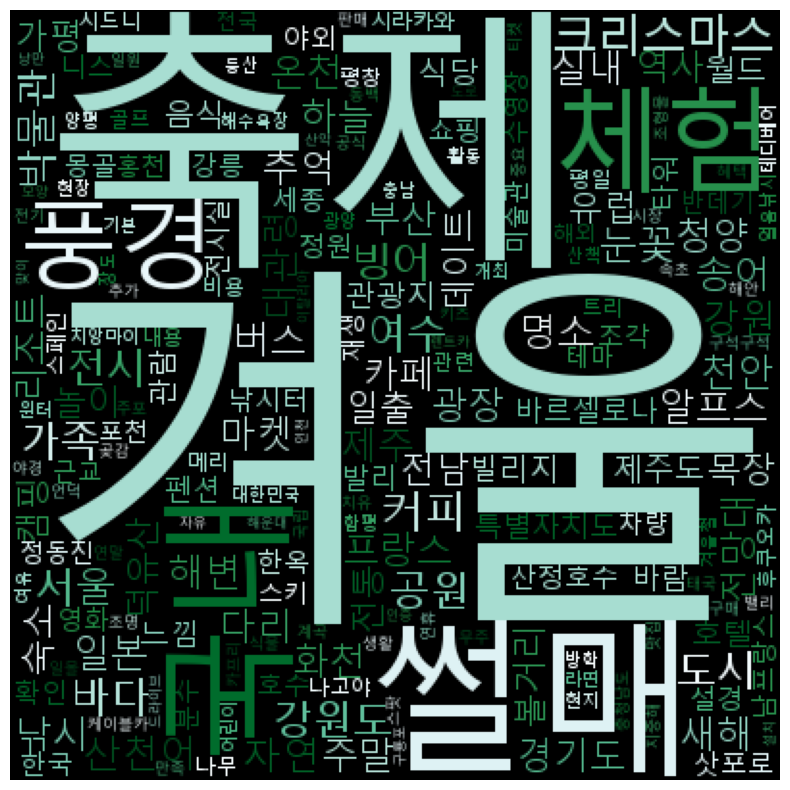

In [38]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')
               ## 'Blues': 파란색 그라데이션
               ## 'BuGn': 청록색
               ## 'BuPu': 진보라 ~ 연한 파란색 ~ 하얀색 
               ## 'GnBu': 진파랑 ~ 연한 초록색 ~ 하얀색
               ## 'Greys': 검은색 ~ 회색 ~ 하얀색
               ## 'OrRd': 진빨강 ~ 연한 오렌지 ~ 하얀색
               ## 'Pastel1': 파스텔 색
               ## 'Pastel2': 파스텔 색
               ## 'PuBu': 진파랑 ~ 핑크 ~ 하얀색
               ## 'PuRd': 자주 ~ 핑크 ~ 하얀색
               ## 'Purples': 보라색
               ## 'RdPu': 보라 ~ 자주 ~ 핑크
               ## 'Reds': 빨강
               ## 'Wistia': 주황 ~ 형광 노랑
               ## 'YlGnBu': 파랑 ~ 초록 ~ 노랑


img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [description WordCloud]

In [26]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_description.set_index('word').to_dict()['count']
dic_word

{'축제': 368,
 '국내': 221,
 '벚꽃': 199,
 '겨울': 137,
 '해외': 135,
 '일본': 96,
 '명소': 85,
 '공원': 82,
 '부산': 77,
 '가족': 65,
 '서울': 64,
 '개화': 63,
 '봄꽃': 56,
 '여행사': 55,
 '연휴': 48,
 '경주': 44,
 '베트남': 41,
 '새해': 40,
 '전남': 40,
 '박람회': 36,
 '태안': 36,
 '제주': 35,
 '여름': 34,
 '연차': 34,
 '대구': 33,
 '주말': 32,
 '경남': 32,
 '해외여행': 32,
 '근교': 32,
 '강원도': 32,
 '충남': 31,
 '도시': 31,
 '신혼': 31,
 '유럽': 31,
 '태국': 30,
 '경기도': 30,
 '삿포로': 29,
 '산수유': 29,
 '관광지': 28,
 '철쭉': 28,
 '남해': 27,
 '체험': 27,
 '바다': 27,
 '전국': 27,
 '고양': 27,
 '일자': 26,
 '공휴일': 26,
 '데이트': 26,
 '전북': 26,
 '전라도': 26,
 '매화': 25,
 '유채': 25,
 '힐링': 24,
 '제주도': 24,
 '스페인': 24,
 '풍경': 24,
 '특가': 24,
 '박물관': 22,
 '인천': 22,
 '장미': 22,
 '울산': 22,
 '자연': 22,
 '도쿄': 21,
 '동남아': 21,
 '광양': 21,
 '골프': 21,
 '카페': 21,
 '강릉': 21,
 '다낭': 21,
 '버스': 20,
 '대만': 20,
 '구례': 20,
 '일요일': 19,
 '기본': 19,
 '맛집': 18,
 '한국': 18,
 '여수': 18,
 '개장': 17,
 '탈출': 17,
 '호주': 17,
 '실내': 17,
 '펜션': 17,
 '방콕': 17,
 '오전': 17,
 '속초': 17,
 '역사': 17,
 '행복': 16,
 '산책': 16,
 '수목원': 1

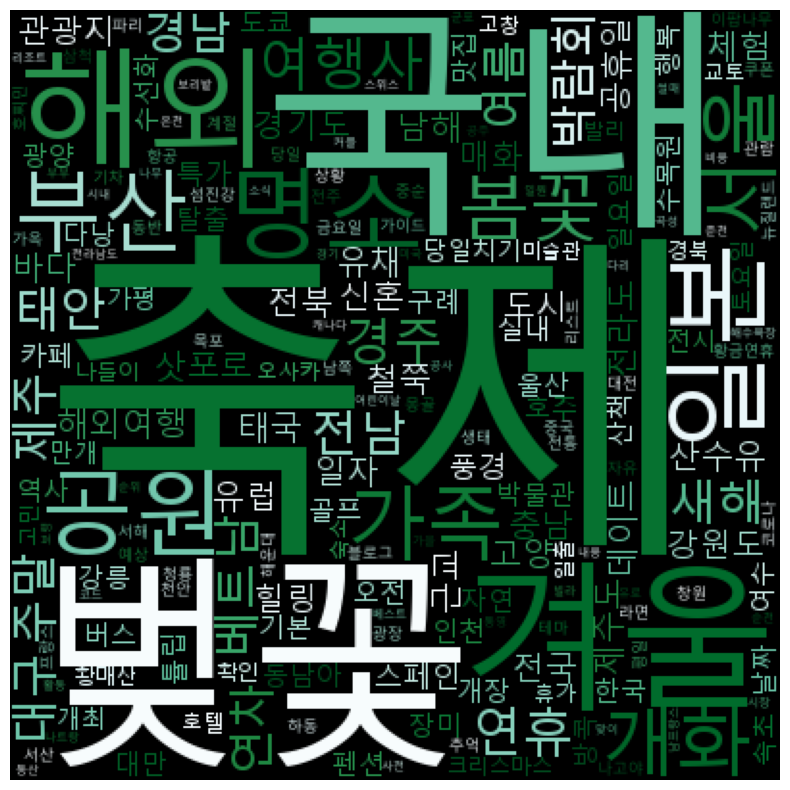

In [27]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기
## plt.savefig('동감_워드클라우드') # 파일 저장

## [title WordCloud]

In [28]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_title.set_index('word').to_dict()['count']
dic_word

{'축제': 201,
 '국내': 177,
 '벚꽃': 116,
 '해외': 113,
 '겨울': 92,
 '명소': 62,
 '부산': 53,
 '개화': 50,
 '일본': 49,
 '가족': 40,
 '봄꽃': 40,
 '공원': 39,
 '서울': 36,
 '근교': 32,
 '제주': 30,
 '경남': 28,
 '전남': 28,
 '해외여행': 27,
 '호텔': 26,
 '강원도': 24,
 '경주': 21,
 '유럽': 20,
 '여행사': 20,
 '연휴': 19,
 '연차': 19,
 '산수유': 18,
 '전북': 18,
 '데이트': 17,
 '전국': 17,
 '매화': 17,
 '제주도': 17,
 '자유': 16,
 '충남': 16,
 '나들이': 16,
 '유채': 15,
 '철쭉': 15,
 '구례': 15,
 '여름': 15,
 '상황': 15,
 '황금연휴': 15,
 '동남아': 15,
 '당일치기': 14,
 '도쿄': 14,
 '남해': 14,
 '대구': 14,
 '전라도': 14,
 '몽골': 14,
 '여수': 13,
 '스페인': 13,
 '공지': 13,
 '도시': 13,
 '광양': 13,
 '리스트': 13,
 '주말': 12,
 '관광지': 12,
 '가평': 12,
 '공휴일': 12,
 '베트남': 12,
 '경북': 12,
 '장미': 12,
 '골프': 12,
 '볼거리': 12,
 '만개': 12,
 '울산': 11,
 '강릉': 11,
 '수선화': 11,
 '통영': 11,
 '태안': 11,
 '풍경': 11,
 '휴가': 11,
 '실내': 11,
 '순위': 11,
 '튤립': 10,
 '실시간': 10,
 '퀘벡': 10,
 '특가': 10,
 '드라이브': 10,
 '전주': 10,
 '인천': 10,
 '새해': 10,
 '다리': 10,
 '옷차림': 10,
 '태국': 9,
 '항공': 9,
 '삼성': 9,
 '삿포로': 9,
 '속초': 9,
 '베스트': 9,
 '박람회':

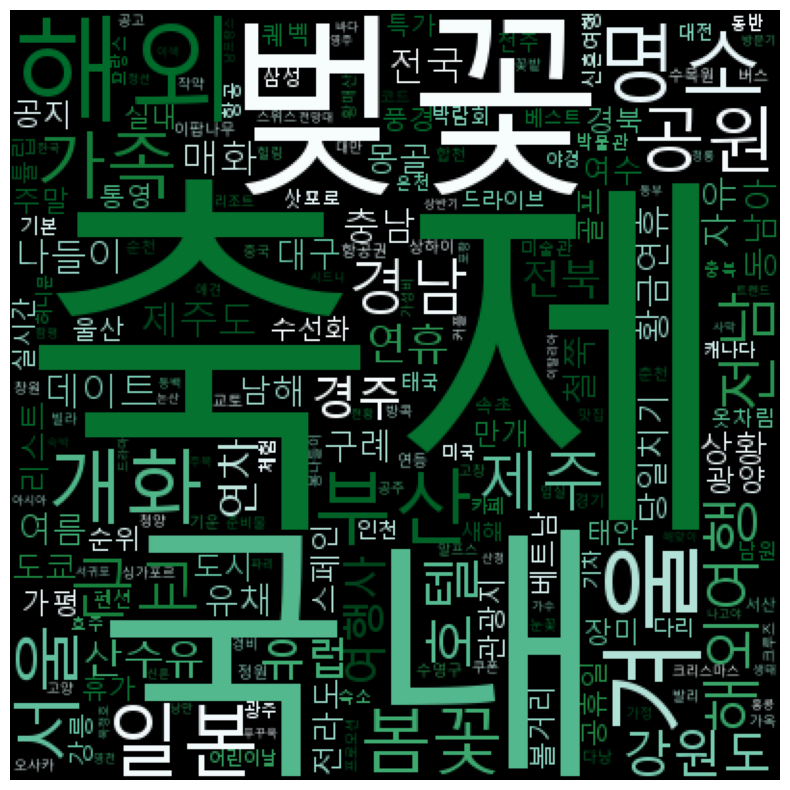

In [29]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

### [Spring WordCloud]

In [30]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = spring_word_counts.set_index('word').to_dict()['count']
dic_word

{'축제': 1678,
 '벚꽃': 1646,
 '공원': 459,
 '명소': 414,
 '국내': 394,
 '체험': 375,
 '산수유': 361,
 '매화': 351,
 '개화': 331,
 '봄꽃': 319,
 '풍경': 222,
 '가족': 221,
 '유채': 220,
 '구례': 208,
 '수선화': 195,
 '서울': 194,
 '장미': 176,
 '경주': 158,
 '튤립': 156,
 '제주': 151,
 '광양': 150,
 '하동': 149,
 '주말': 149,
 '전남': 149,
 '경기도': 147,
 '나무': 146,
 '경남': 142,
 '쿠폰': 140,
 '부산': 139,
 '정원': 136,
 '영주': 135,
 '만개': 132,
 '일본': 121,
 '철쭉': 118,
 '대구': 116,
 '카페': 116,
 '속초': 113,
 '바다': 112,
 '선비': 112,
 '서산': 111,
 '박람회': 111,
 '남해': 107,
 '가옥': 107,
 '산책': 105,
 '볼거리': 101,
 '호텔': 101,
 '재생': 101,
 '인천': 100,
 '여수': 99,
 '적용': 96,
 '나들이': 95,
 '버스': 95,
 '놀이': 94,
 '숙소': 93,
 '힐링': 93,
 '고양': 92,
 '전국': 89,
 '전망대': 88,
 '어린이': 88,
 '한국': 87,
 '자연': 87,
 '특가': 86,
 '충남': 85,
 '근교': 83,
 '역사': 83,
 '관광지': 82,
 '가평': 80,
 '전통': 80,
 '확인': 80,
 '일원': 79,
 '데이트': 79,
 '경상남도': 78,
 '호수': 76,
 '남도': 75,
 '수목원': 74,
 '커피': 74,
 '참여': 71,
 '제주도': 70,
 '교토': 68,
 '만끽': 68,
 '진달래': 68,
 '무대': 68,
 '추억': 68,
 '해외': 67,
 '강진': 66,


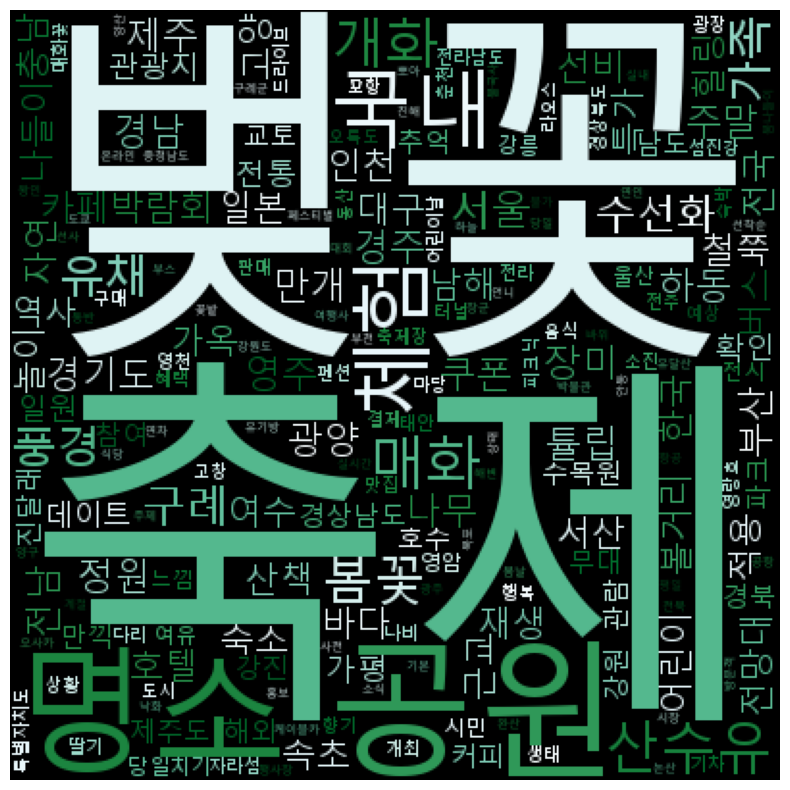

In [31]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

### [Summer WordCloud]

In [32]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = summer_word_counts.set_index('word').to_dict()['count']
dic_word

{'여름': 139,
 '일본': 100,
 '해외': 94,
 '호텔': 83,
 '마카오': 82,
 '도시': 75,
 '축제': 73,
 '중국': 68,
 '오키나와': 67,
 '바다': 63,
 '파리': 61,
 '한국': 54,
 '기온': 53,
 '가족': 52,
 '몽골': 50,
 '비자': 47,
 '스위스': 45,
 '호수': 44,
 '제주': 44,
 '풍경': 43,
 '골프': 40,
 '해변': 40,
 '숙소': 39,
 '전주': 38,
 '호주': 38,
 '국내': 37,
 '명소': 37,
 '체험': 36,
 '여행사': 36,
 '해외여행': 36,
 '장마': 36,
 '자연': 35,
 '대만': 35,
 '태국': 34,
 '음식': 34,
 '쿠폰': 34,
 '유럽': 32,
 '해양': 31,
 '남미': 31,
 '프랑스': 31,
 '장항': 31,
 '공원': 30,
 '연차': 30,
 '싱가포르': 30,
 '역사': 30,
 '카페': 30,
 '나트랑': 30,
 '구매': 29,
 '평균': 29,
 '경주': 28,
 '휴가': 28,
 '페루': 27,
 '융프라우': 27,
 '정원': 27,
 '쿠스코': 27,
 '방콕': 27,
 '베트남': 25,
 '야경': 25,
 '활동': 25,
 '쇼핑': 24,
 '삿포로': 24,
 '전통': 23,
 '도움': 23,
 '국립': 23,
 '타이베이': 23,
 '별궁': 23,
 '현지': 22,
 '동남아': 22,
 '관광지': 22,
 '프로': 22,
 '국제': 21,
 '우산': 21,
 '물가': 21,
 '옷차림': 21,
 '일산': 21,
 '사이트': 21,
 '버스': 21,
 '다낭': 21,
 '확인': 20,
 '인천': 20,
 '리조트': 20,
 '태풍': 20,
 '경기': 20,
 '연휴': 20,
 '근교': 19,
 '세부': 19,
 '라면': 19,
 '블로그': 19,
 '대비':

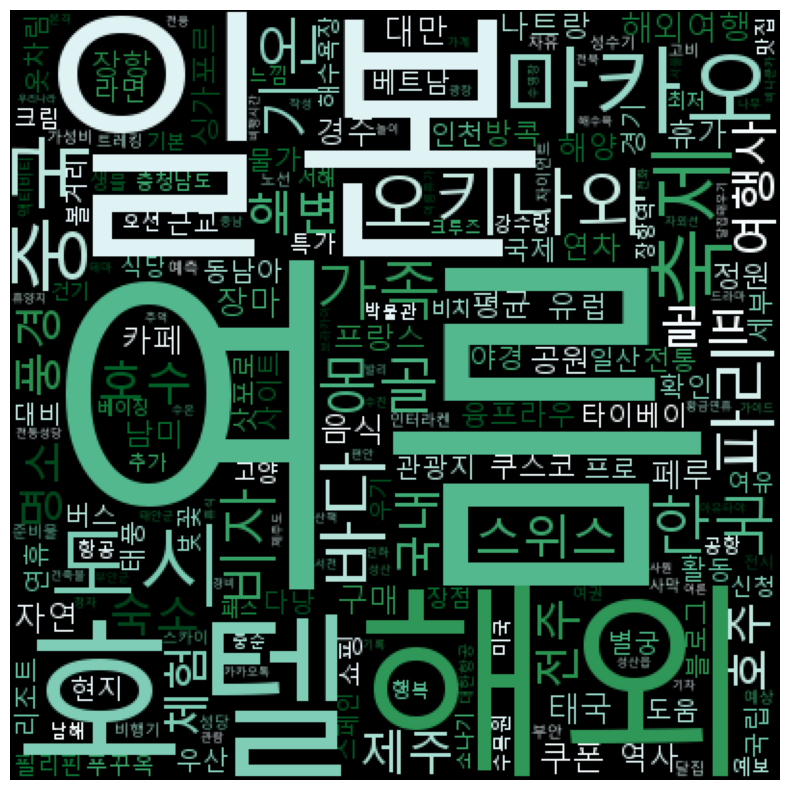

In [33]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

### [Autumn WordCloud]

In [34]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = autumn_word_counts.set_index('word').to_dict()['count']
dic_word

{'크루즈': 63,
 '순천': 37,
 '순천만': 31,
 '가을': 31,
 '습지': 26,
 '퀘벡': 24,
 '캐나다': 23,
 '연산': 19,
 '한진': 18,
 '창고': 17,
 '연등': 17,
 '멜버른': 16,
 '호텔': 16,
 '전시': 15,
 '호주': 14,
 '발리': 14,
 '여행사': 14,
 '국내': 14,
 '가이드': 14,
 '일몰': 12,
 '갈대밭': 12,
 '축제': 11,
 '해외': 11,
 '전남': 11,
 '체험': 11,
 '항공': 10,
 '대장': 10,
 '감사': 10,
 '정원': 9,
 '여유': 9,
 '비용': 9,
 '차장': 9,
 '고정': 9,
 '인천': 9,
 '호치민': 9,
 '경비': 8,
 '말씀': 8,
 '연산역': 8,
 '관람': 8,
 '군락지': 7,
 '라이트': 7,
 '시장': 7,
 '메리즈빌': 7,
 '선내': 7,
 '명소': 7,
 '역사': 7,
 '차량': 7,
 '대한항공': 7,
 '풍경': 7,
 '여정': 7,
 '직항': 7,
 '사항': 7,
 '동유럽': 6,
 '추억': 6,
 '야간': 6,
 '행복': 6,
 '쇼핑': 6,
 '아프리카': 6,
 '고민': 6,
 '고객': 6,
 '미국': 6,
 '삼광사': 6,
 '편안': 6,
 '몬트리올': 6,
 '현지': 6,
 '옵션': 6,
 '선박': 5,
 '선사': 5,
 '숩숩': 5,
 '북동쪽': 5,
 '가족': 5,
 '객실': 5,
 '노을': 5,
 '만족': 5,
 '갈대': 5,
 '물가': 5,
 '유럽': 5,
 '불국사': 5,
 '카페': 5,
 '맥주': 5,
 '논산': 5,
 '시드니': 5,
 '음식': 5,
 '관광지': 5,
 '중요': 5,
 '단풍': 5,
 '카드': 5,
 '발급': 5,
 '기획': 5,
 '항공료': 5,
 '금액': 5,
 '왕복': 5,
 '여자': 4,
 '송출': 4,
 '일본':

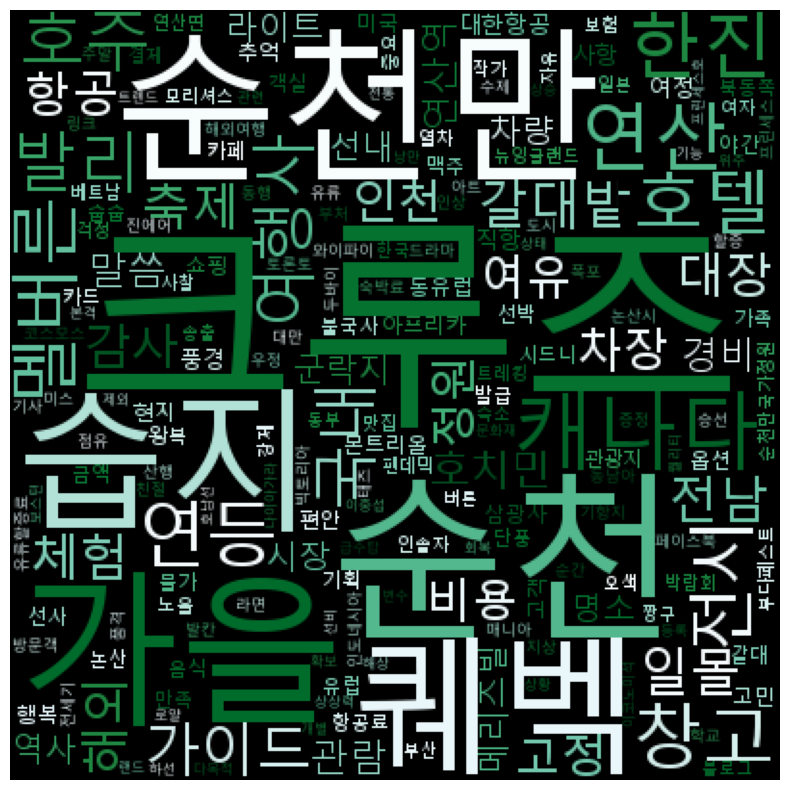

In [35]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

### [Winter WordCloud]

In [36]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = winter_word_counts.set_index('word').to_dict()['count']
dic_word

{'겨울': 710,
 '축제': 665,
 '썰매': 351,
 '국내': 234,
 '체험': 213,
 '풍경': 159,
 '크리스마스': 158,
 '커피': 151,
 '바다': 132,
 '가족': 129,
 '서울': 129,
 '박물관': 126,
 '공원': 126,
 '강원도': 124,
 '도시': 122,
 '빙어': 120,
 '전시': 117,
 '여수': 113,
 '낚시': 106,
 '명소': 105,
 '일본': 104,
 '눈꽃': 101,
 '자연': 97,
 '산천어': 94,
 '송어': 93,
 '대관령': 86,
 '알프스': 85,
 '카페': 83,
 '제주': 83,
 '실내': 79,
 '해변': 79,
 '온천': 79,
 '화천': 76,
 '마켓': 76,
 '경기도': 75,
 '하늘': 74,
 '숙소': 73,
 '청양': 72,
 '프랑스': 71,
 '새해': 70,
 '전망대': 70,
 '부산': 69,
 '리조트': 68,
 '광장': 68,
 '다리': 67,
 '주말': 66,
 '추억': 66,
 '천안': 65,
 '버스': 64,
 '강원': 64,
 '놀이': 58,
 '목장': 57,
 '일출': 57,
 '역사': 57,
 '데이트': 57,
 '가평': 55,
 '덕유산': 55,
 '전남': 54,
 '캠핑': 54,
 '볼거리': 53,
 '유럽': 53,
 '전통': 53,
 '제주도': 52,
 '월드': 52,
 '빌리지': 52,
 '음식': 52,
 '식당': 52,
 '느낌': 51,
 '호텔': 50,
 '관광지': 49,
 '특별자치도': 49,
 '바람': 49,
 '타워': 48,
 '펜션': 48,
 '관람': 47,
 '발리': 47,
 '바르셀로나': 45,
 '산정호수': 45,
 '야외': 45,
 '몽골': 44,
 '삿포로': 44,
 '정원': 44,
 '확인': 44,
 '조각': 43,
 '남프랑스': 43,
 '니스': 43,
 '낚

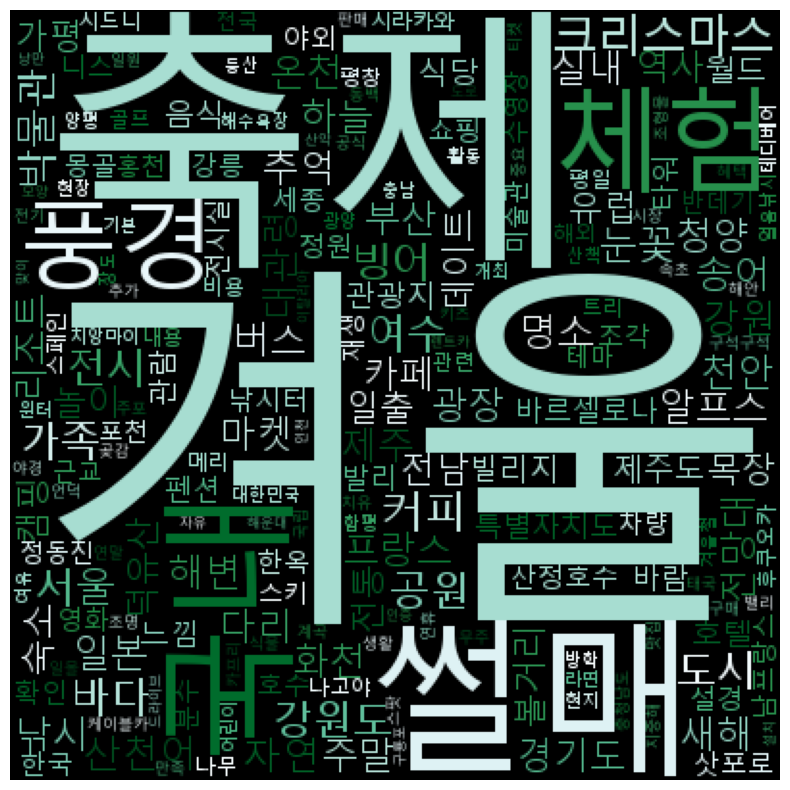

In [37]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'BuGn')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기